# Refinement

Mostly a replicaiton of what was done if Pump-02, where we did data transformation and GridCV Selection.

As we futher took the data transformation of Variance Threshold checking and KBest Features selection, we need to recheck our evaluation methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from scripts.tools import sam_pickle_load, df_check_stats, check_metric
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import chi2, SelectPercentile, VarianceThreshold, SelectKBest
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline


np.set_printoptions(precision=5)
np.random.seed(69572)
plt.style.use('ggplot')
sns.set(color_codes=True)

crazy_list = dir()

In [61]:
for each in dir():
    if each not in crazy_list:
        del each

print('Length of dir():', len(dir()))

Length of dir(): 150


In [62]:
X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration2_final_')

# preprocess dataset, split into training and test part
# X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.25, random_state=42)

LOAD PREFIX USED:  tmp/Iteration2_final_


In [63]:
X.head()

,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,population,public_meeting,...,payment_type,quality_group,quantity,quantity_group,source,waterpoint_type,date_recorded_month,Area,Population02,Population12
id,,,,,,,,,,,,,,,,,,,,,
69572,54,704,1443,789,33612,6653,1,3,109,1,...,0,2,1,1,8,1,2,10,2,1
8776,322,793,1452,789,30637,62952,4,9,279,0,...,2,2,2,2,5,1,2,5,10,11
34310,313,793,738,962,53202,46457,5,8,250,1,...,5,2,1,1,0,2,1,14,4,7
67743,285,894,315,884,59963,611,7,12,58,1,...,2,2,0,0,3,2,0,3,7,4
19728,111,793,1114,789,5831,64510,4,4,0,1,...,2,2,3,3,5,1,6,7,17,17


In [64]:
X.shape

(59400, 25)

In [65]:
X.dtypes

date_recorded          int64
funder                 int64
gps_height             int64
installer              int64
longitude              int64
latitude               int64
basin                  int64
region                 int64
population             int64
public_meeting         int64
scheme_management      int64
permit                 int64
construction_year      int64
extraction_type        int64
management             int64
payment_type           int64
quality_group          int64
quantity               int64
quantity_group         int64
source                 int64
waterpoint_type        int64
date_recorded_month    int64
Area                   int64
Population02           int64
Population12           int64
dtype: object

# XGboost Learning Curve

Understanding of how well the models trains might help us to know if the model if learning as time procceds or its stagnated after learning just few sample of data.

In [66]:
import xgboost as xgb

In [67]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(12, 5))
    plt.title(title, fontsize=9)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontsize=8)
    plt.ylabel("Score", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    print('---------------------------------------')
    print('train_sizes', train_sizes)
    print('train_scores', train_scores)
    print('test_scores', test_scores)
    print('---------------------------------------')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

---------------------------------------
train_sizes [ 4751 10861 16971 23080 29190 35299 41409 47519]
train_scores [[ 0.76468  0.75879  0.75879  0.75879  0.75879]
 [ 0.75251  0.74993  0.74993  0.74993  0.74993]
 [ 0.75594  0.75317  0.7524   0.7524   0.7524 ]
 [ 0.74866  0.74467  0.74987  0.74987  0.74987]
 [ 0.74752  0.74573  0.7469   0.75067  0.75067]
 [ 0.74719  0.74676  0.74824  0.74492  0.74492]
 [ 0.74822  0.74781  0.74636  0.74602  0.74629]
 [ 0.74833  0.74806  0.74863  0.74768  0.7465 ]]
test_scores [[ 0.73933  0.72721  0.72929  0.72971  0.73363]
 [ 0.74312  0.73479  0.73569  0.7367   0.7428 ]
 [ 0.74506  0.73698  0.73998  0.7415   0.74592]
 [ 0.74674  0.73731  0.7415   0.74234  0.74836]
 [ 0.74413  0.74009  0.74268  0.74402  0.74962]
 [ 0.74657  0.74144  0.74487  0.742    0.74701]
 [ 0.74506  0.74219  0.74192  0.74436  0.74912]
 [ 0.74573  0.74127  0.74192  0.74369  0.75004]]
---------------------------------------


<module 'matplotlib.pyplot' from '/Users/sampathm/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

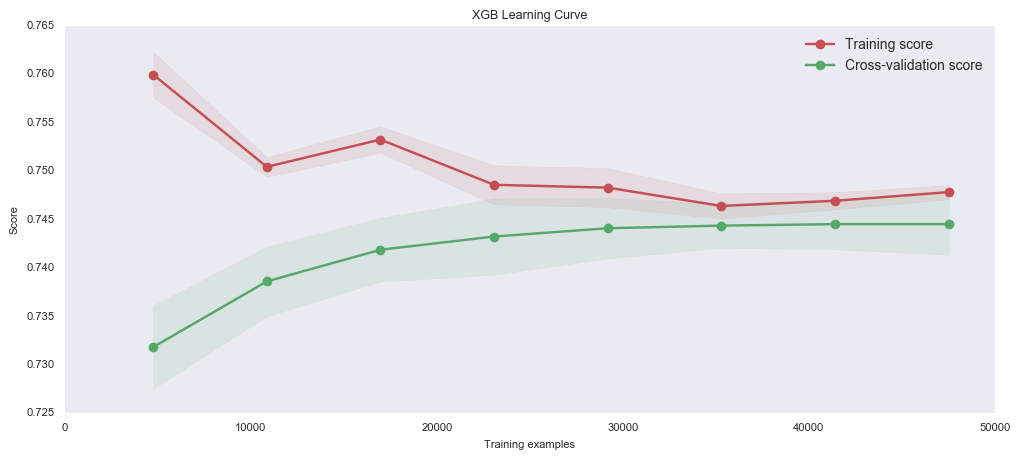

In [68]:
estimator = xgb.XGBClassifier()

plot_learning_curve(estimator=estimator, title='XGB Learning Curve', X=X, y=y, ylim=None, cv=5,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 8))

In [69]:
np.linspace(.1, 1.0, 8)

array([ 0.1    ,  0.22857,  0.35714,  0.48571,  0.61429,  0.74286,
        0.87143,  1.     ])

In [70]:
estimator

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

As you can see from above diagram, there are 3 features to identify

* Sudden drop at 10K sample point.
* Light Green Aura of Green Line & Green Line is slowly reducing till it reached 30K sample.
* After 30K Sample point, both the score and the green Aura sighly declined.
* After 30K Sample point, Red Aura slowly started decreasing futher.


Based on these features, I believe we can understand that our Xgboost learning kind of stagnated aroudn 30K records point. Overall, we can learn that Algorithm is learning well and reached it stagnation point with current parameters. So either we tune the Algorithm feature to keep learning or we can limit the training data at 30K Limit.

I believe limiting data is bad as it would be a waste of valuble data, we will continue parameter tuning to keep learning.

# Fine Tuning

Pipeling is a meathod of combining several transformaiton techniques and a classifier to run them one after the other

In [2]:
print('Length of dir():', len(dir()))

for each in dir():
    if each not in crazy_list:
        del each

print('Length of dir():', len(dir()))

Length of dir(): 45
Length of dir(): 46


In [3]:
X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration2_final_')

# preprocess dataset, split into training and test part
# X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=.25, random_state=42)

LOAD PREFIX USED:  tmp/Iteration2_final_


In [6]:
X.shape

(59400, 25)

In [8]:
threshold_fns = lambda x: (x * (1 - x))

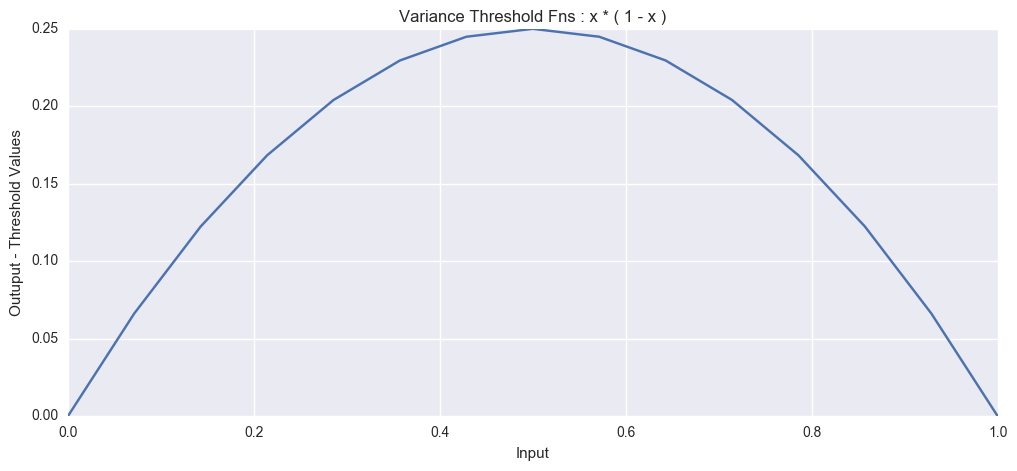

In [17]:
plt.figure(figsize=(12, 5))

plt.title('Variance Threshold Fns : x * ( 1 - x )')
plt.plot(np.linspace(0, 1, 15), [threshold_fns(_) for _ in np.linspace(0, 1, 15)])
plt.xlabel('Input')
plt.ylabel('Outuput - Threshold Values')

Variance Threshold func, is to set the variance limit of a columns throught a Threshold Limit. Thus doing variance threshold check and removing features which more than threshold generally help ML algorithms to understand patterns.

Also removing such features which has too high threshold also help ML Algo, to focus on exsiting data rather than wasting time and resource on difficult to learn features.

In [25]:
#############################################################################
# Variance Check
vt = VarianceThreshold(threshold=(0.85 * (1 - 0.85)))
threshold_fns = lambda x: (x * (1 - x))
# Select K Best
selection = SelectKBest(chi2)
# Features Selector - Union
combined_features = FeatureUnion([("vt", vt), ("univ_select", selection)])
#############################################################################
# Classifier
clf = xgb.XGBClassifier()
#############################################################################
# Piplining
pipeline = Pipeline([("features", combined_features), ("clf", clf)])


param_grid = dict(features__vt__threshold=[threshold_fns(.65), threshold_fns(.75), threshold_fns(.85)],
                  features__univ_select__k=[15, 20, 25],
                  clf__n_estimators=[100, 150],
                  clf__max_depth=[3, 5],
                  clf__learning_rate=[.3, .1]
                  )

RS = RandomizedSearchCV(pipeline, param_grid, n_iter=10, n_jobs=-1, verbose=1)

In [26]:
RS

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('vt', VarianceThreshold(threshold=0.1275)), ('univ_select', SelectKBest(k=10, score_func=<function chi2 at 0x10dfd6d90>))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_byt...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'clf__max_depth': [3, 5], 'features__vt__threshold': [0.22749999999999998, 0.1875, 0.1275], 'clf__n_estimators': [100, 150], 'clf__learning_rate': [0.3, 0.1], 'features__univ_select__k': [15, 20, 25]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=1)

In [27]:
RS.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.7min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('vt', VarianceThreshold(threshold=0.1275)), ('univ_select', SelectKBest(k=10, score_func=<function chi2 at 0x10dfd6d90>))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_byt...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'clf__max_depth': [3, 5], 'features__vt__threshold': [0.22749999999999998, 0.1875, 0.1275], 'clf__n_estimators': [100, 150], 'clf__learning_rate': [0.3, 0.1], 'features__univ_select__k': [15, 20, 25]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=1)

In [28]:
RS.best_estimator_

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('vt', VarianceThreshold(threshold=0.22749999999999998)), ('univ_select', SelectKBest(k=15, score_func=<function chi2 at 0x10dfd6d90>))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, ...softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [30]:
RS.best_params_, RS.best_score_

({'clf__learning_rate': 0.3,
  'clf__max_depth': 5,
  'clf__n_estimators': 100,
  'features__univ_select__k': 15,
  'features__vt__threshold': 0.22749999999999998},
 0.79138047138047141)

__ Learning Curve of Best Param __

In [31]:
#############################################################################
# Variance Check
vt = VarianceThreshold(threshold=0.22749999999999998)

# Select K Best
selection = SelectKBest(chi2, k=15)

# Features Selector - Union
combined_features = FeatureUnion([("vt", vt), ("univ_select", selection)])
#############################################################################
# Classifier
clf = xgb.XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=5)
#############################################################################
# Piplining
# pipeline = Pipeline([("features", combined_features), ("clf", clf)])

In [34]:
X_new = combined_features.fit_transform(X, y)

In [45]:
np.linspace(.1, 1.0, 8)

array([ 0.1    ,  0.22857,  0.35714,  0.48571,  0.61429,  0.74286,
        0.87143,  1.     ])

---------------------------------------
train_sizes [24325 29417 34508 39600]
train_scores [[ 0.83651  0.83276  0.83959]
 [ 0.82881  0.82857  0.83258]
 [ 0.82595  0.82613  0.82987]
 [ 0.82629  0.82409  0.82439]]
test_scores [[ 0.78394  0.78783  0.78434]
 [ 0.78697  0.78793  0.78591]
 [ 0.78798  0.79288  0.78758]
 [ 0.78985  0.79495  0.78934]]
---------------------------------------


<module 'matplotlib.pyplot' from '/Users/sampathm/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

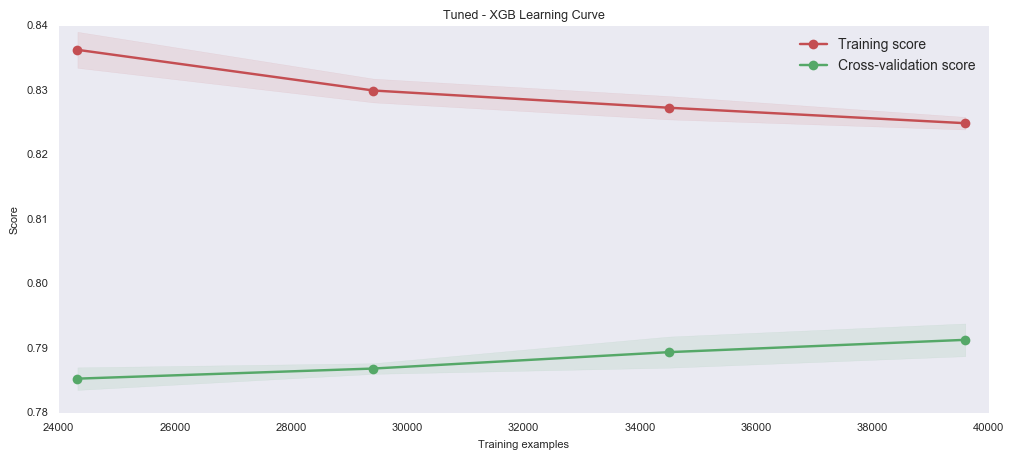

In [46]:
plot_learning_curve(estimator=clf,
                    title='Tuned - XGB Learning Curve',
#                     X=X, # Optimised to X_new
                    X=X_new,
                    y=y, ylim=None, cv=3,
                    n_jobs=1,
#                     train_sizes=np.linspace(.1, 1.0, 8), # optimising search space
                    train_sizes=[0.61429, 0.74286, 0.87143, 1.0 ]
                   )

In [47]:
np.linspace(0, 1, 10)

array([ 0.     ,  0.11111,  0.22222,  0.33333,  0.44444,  0.55556,
        0.66667,  0.77778,  0.88889,  1.     ])

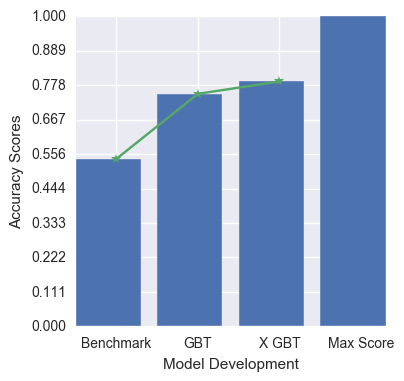

In [54]:
plt.figure(figsize=(4, 4))

plt.bar([1, 2, 3, 4], [ .54, .75, .79, 1])

plt.xticks([1.5, 2.5, 3.5, 4.5], ['Benchmark', 'GBT', 'X GBT', 'Max Score'])

plt.yticks(np.linspace(0, 1, 10))

plt.ylabel('Accuracy Scores')
plt.xlabel('Model Development')

plt.plot([1.5, 2.5, 3.5],  [.54, .75, .79], '*g-')


In [68]:
new_X = combined_features.transform(X)

In [65]:
values_counts_bag = [len(X[column].value_counts()) for column in new_X.columns]
cols_vc_dataframe = pd.DataFrame(np.log(values_counts_bag), index=new_X.columns, columns=['Value Counts'])

We seem to have some special categories where value counts are high.


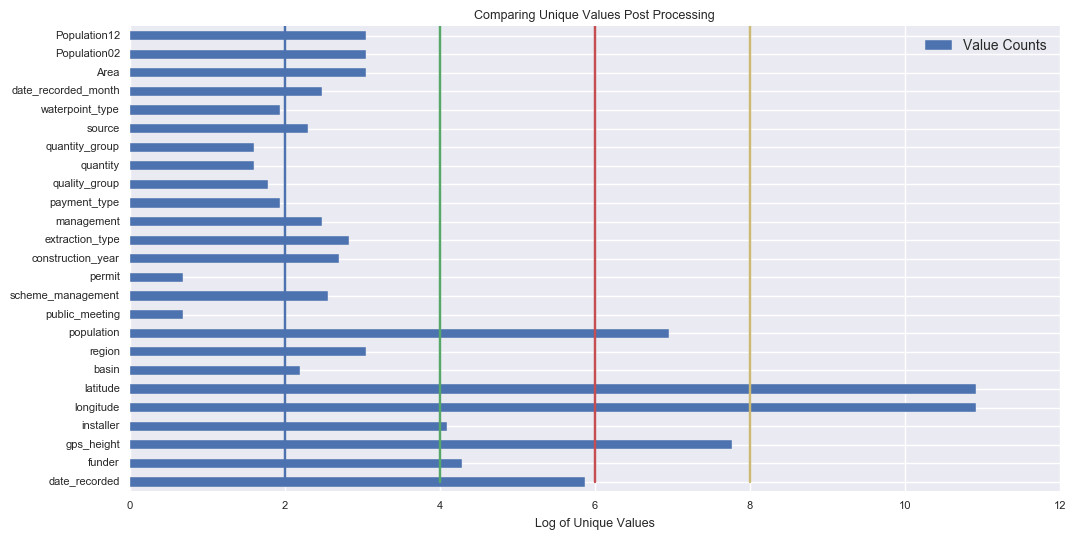

In [67]:
cols_vc_dataframe.plot(kind='barh', figsize=(12, 6), fontsize=8)
_ = plt.plot((2, 2), (0, 38))
_ = plt.plot((4, 4), (0, 38), '-g')
_ = plt.plot((6, 6), (0, 38), '-r')
_ = plt.plot((8, 8), (0, 38), '-y')
print('We seem to have some special categories where value counts are high.')

_ = plt.title('Comparing Unique Values Post Processing', fontsize=9)
_ = plt.xlabel('Log of Unique Values', fontsize=9)

# Submit

In [57]:
# Load Data
X, y, TEST_X = sam_pickle_load(prefix='tmp/Iteration2_final_')

# Variance Check
vt = VarianceThreshold(threshold=0.22749999999999998)

# Select K Best
selection = SelectKBest(chi2, k=15)

# Features Selector - Union
combined_features = FeatureUnion([("vt", vt), ("univ_select", selection)])

# saving the index
test_ids = TEST_X.index

# Data Transformations
X = combined_features.fit_transform(X, y)
TEST_X = combined_features.transform(TEST_X)

LOAD PREFIX USED:  tmp/Iteration2_final_


In [58]:
# Classifier modeling
clf = xgb.XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=5)

# Classifier training
clf = clf.fit(X_new, y)

In [59]:
# loading pickle to de-transform y into lables
le = pickle.load(open('tmp/le.pkl', 'rb'))

# predicint the values
predictions = clf.predict(TEST_X)
print(predictions.shape)

# Converting int to its respective Labels
predictions_labels = le.inverse_transform(predictions)

# setting up column name & save file
sub = pd.DataFrame(predictions_labels, columns=['status_group'])
sub.head()
sub.insert(loc=0, column='id', value=test_ids)
sub.reset_index()
sub.to_csv('submit.csv', index=False)
sub.head()

(14850,)


,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
